### Basic Language Translation Using Transformers

- Multi30k Dataset

In [1]:
import math
import random
import time

import os
from pathlib import Path

import torch
import torch.nn.functional as F

from torch import nn, optim, Tensor
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt

from collections import Counter

from datasets import Dataset, load_dataset
from tqdm import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device is {device}")

Device is cuda


In [3]:
!nvidia-smi

Wed Nov 20 19:33:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:81:00.0 Off |                   On |
| N/A   35C    P0             150W / 500W |   5034MiB / 81920MiB |     N/A      Default |
|                                         |                      |              Enabled |
+-----------------------------------------+----------------------+--

In [3]:
ds = load_dataset("bentrevett/multi30k", split="train+test+validation")

In [4]:
ds

Dataset({
    features: ['en', 'de'],
    num_rows: 31014
})

In [5]:
train_ds = load_dataset("bentrevett/multi30k", split="train")
val_ds = load_dataset("bentrevett/multi30k", split="validation")
test_ds = load_dataset("bentrevett/multi30k", split="test")

In [6]:
train_ds.features

{'en': Value(dtype='string', id=None), 'de': Value(dtype='string', id=None)}

In [7]:
train_ds[0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}

## Training a tokenizer on the whole corpus

In [8]:
PAD_IDX = 0
BOS_IDX = 1
EOS_IDX = 2
UNK_IDX = 3

In [9]:
tokenizers_path = Path("tokenizers")

if not tokenizers_path.exists():
    tokenizers_path.mkdir(parents=True, exist_ok=True)

#### ByteLevelBPE Tokenizer

In [10]:
from tokenizers import ByteLevelBPETokenizer, Tokenizer
from transformers import PreTrainedTokenizerFast
from tokenizers.processors import TemplateProcessing

In [11]:
def batch_iterator(dataset, batch_size: int = 1000, column: str = "en"):
    # select the passed column
    tok_dataset = dataset.select_columns(column)

    for batch in tok_dataset.iter(batch_size):
        yield batch[column]
        
def train_tokenizer(dataset, column: str = "en", vsize: int = 20000, min_freq: int = 2) -> Tokenizer:
    tokenizer = ByteLevelBPETokenizer()
    
    tokenizer.train_from_iterator(
        batch_iterator(dataset = dataset, column=column), 
        vocab_size = vsize, 
        min_frequency = min_freq, 
        special_tokens = ["[PAD]", "[BOS]", "[EOS]", "[UNK]"]
    )
    
    return tokenizer

In [12]:
en_byte_path = tokenizers_path / "english_byte_tokenizer.json"
de_byte_path = tokenizers_path / "german_byte_tokenizer.json"

if not en_byte_path.exists() or not de_byte_path.exists():
    #train the tokenizers
    en_byte_tokenizer = train_tokenizer(dataset = ds, column = "en")
    de_byte_tokenizer = train_tokenizer(dataset = ds, column = "de")
    
    en_byte_tokenizer.post_processor = TemplateProcessing(
        single = "[BOS] $A [EOS]",
        special_tokens = [("[BOS]", BOS_IDX),  ("[EOS]", EOS_IDX)],
    )
    
    de_byte_tokenizer.post_processor = TemplateProcessing(
        single = "[BOS] $A [EOS]",
        special_tokens = [("[BOS]", BOS_IDX),  ("[EOS]", EOS_IDX)],
    )
    
    #save the tokenizers
    en_byte_tokenizer.save(str(en_byte_path))
    de_byte_tokenizer.save(str(de_byte_path))
    
    

#Load the saved tokenizers into fast PreTrainedTokenizer Object
en_byte_tokenizer = PreTrainedTokenizerFast(tokenizer_file = str(en_byte_path))
de_byte_tokenizer = PreTrainedTokenizerFast(tokenizer_file = str(de_byte_path))


special_tokens_dict = {
    'pad_token': '[PAD]',
    'unk_token': '[UNK]',
    'bos_token': '[BOS]',
    'eos_token': '[EOS]'
}

en_byte_tokenizer.add_special_tokens(special_tokens_dict)
de_byte_tokenizer.add_special_tokens(special_tokens_dict)

0

In [13]:
## example usage of tokenizer
input_text = "This is a test"

print(en_byte_tokenizer.tokenize(input_text))  #returns list of tokens
print(en_byte_tokenizer.encode(input_text))
print(en_byte_tokenizer.encode(input_text, return_tensors = 'pt'))
print(en_byte_tokenizer(input_text))


['This', 'Ġis', 'Ġa', 'Ġtest']
[1, 1069, 293, 260, 5564, 2]
tensor([[   1, 1069,  293,  260, 5564,    2]])
{'input_ids': [1, 1069, 293, 260, 5564, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}


In [14]:
## example usage of tokenizer
input_text = "Good morning, wake up it's a new day"

print(en_byte_tokenizer.tokenize(input_text))  #returns list of tokens
print(en_byte_tokenizer.encode(input_text, return_tensors = 'pt'))

['Good', 'Ġmorning', ',', 'Ġwake', 'Ġup', 'Ġit', "'s", 'Ġa', 'Ġnew', 'Ġday']
tensor([[   1, 8703, 4645,   15, 3759,  461,  610,  639,  260, 1091,  848,    2]])


In [15]:
## example usage of tokenizer gibberish
input_text = "kabcskjacnaljclnjnalvalj 🤗"

print(en_byte_tokenizer.tokenize(input_text))  #returns list of tokens
print(en_byte_tokenizer.encode(input_text, return_tensors = 'pt'))

['k', 'ab', 'c', 'sk', 'j', 'ac', 'nal', 'j', 'cl', 'n', 'j', 'nal', 'val', 'j', 'Ġ', 'ð', 'Ł', '¤', 'Ĺ']
tensor([[   1,   78, 2047,   70, 1965,   77, 1127, 5995,   77, 1546,   81,   77,
         5995, 3863,   77,  224,  176,  257,  101,  249,    2]])


In [16]:
print("English ByteLevelBPE vocab size is", en_byte_tokenizer.vocab_size)
print("German ByteLevelBPE vocab size is", de_byte_tokenizer.vocab_size)

English ByteLevelBPE vocab size is 10878
German ByteLevelBPE vocab size is 17364


#### Sentencepiece BPE Tokenizer 

In [17]:
import sentencepiece as spm

In [24]:
def train_sentencepiece(
    path: str,                        # Path to the training corpus file
    model_prefix: str,                 # Prefix for the output model and vocab files
    vocab_size: int = 20000,            # Vocabulary size
    model_type: str = "bpe",           # Model type: 'unigram', 'bpe', 'char', or 'word'
    character_coverage: float = 1.0,   # Proportion of characters covered by the model (useful for non-English languages)
    max_sentence_length: int = 2048,   # Max sentence length during training
):
    # Train the SentencePiece model with the specified arguments
    tokenizer = spm.SentencePieceTrainer
    tokenizer.train(
        input = path,
        model_prefix = model_prefix,
        vocab_size = vocab_size,
        model_type = model_type,
        character_coverage = character_coverage,
        minloglevel = 2,
        max_sentence_length=max_sentence_length,
        pad_id = PAD_IDX,                        # ID for <PAD> 0
        bos_id = BOS_IDX,                        # ID for <BOS> 1
        eos_id = EOS_IDX,                        # ID for <EOS> 2
        unk_id = UNK_IDX,                        # ID for <UNK> 3
        unk_piece = "[UNK]",
        bos_piece = "[BOS]",
        eos_piece = "[EOS]",
        pad_piece = "[PAD]",
        unk_surface = "[UNK]"
        
    )
    
    print(f"SentencePiece model '{model_prefix}.model' and vocabulary '{model_prefix}.vocab' saved.")

In [25]:
en_spm_path = tokenizers_path / "english_spm_tokenizer"
de_spm_path = tokenizers_path / "german_spm_tokenizer"

if not en_spm_path.exists or not de_spm_path.exists:
    #train on english data
    train_sentencepiece(path = "dataset/multi30k/en-multi30k.txt", model_prefix = Path("tokenizers/english_spm_tokenizer"), vocab_size = 10000)

    #train on german data
    train_sentencepiece(path = "dataset/multi30k/de-multi30k.txt", model_prefix =  Path("tokenizers/german_spm_tokenizer"), vocab_size = 15000)


In [26]:
en_spm_tokenizer = spm.SentencePieceProcessor(model_file = str(en_spm_path) + ".model")
de_spm_tokenizer = spm.SentencePieceProcessor(model_file = str(de_spm_path) + ".model")

In [27]:
## example usage of tokenizer
input_text = "kabcskjacnaljclnjnalvalj 🤗"

print(en_spm_tokenizer.tokenize(input_text))  #returns list of tokens
print(en_spm_tokenizer.encode_as_pieces(input_text))

[192, 1794, 9934, 1714, 9947, 884, 5722, 9947, 1299, 9923, 9947, 5722, 3613, 9947, 9920, 3]
['▁k', 'ab', 'c', 'sk', 'j', 'ac', 'nal', 'j', 'cl', 'n', 'j', 'nal', 'val', 'j', '▁', '🤗']


In [28]:
## example usage of tokenizer
input_text = "Good morning, wake up it's a new day"

print(en_spm_tokenizer.tokenize(input_text))  #returns list of tokens
print(en_spm_tokenizer.encode_as_pieces(input_text))

[7473, 4546, 9946, 3507, 207, 361, 9955, 9928, 4, 846, 600]
['▁Good', '▁morning', ',', '▁wake', '▁up', '▁it', "'", 's', '▁a', '▁new', '▁day']


In [29]:
print("English SentencePiece vocab size is", en_spm_tokenizer.vocab_size())
print("German SentencePiece vocab size is", de_spm_tokenizer.vocab_size())

English SentencePiece vocab size is 10000
German SentencePiece vocab size is 15000


## Prepare Dataloader

In [30]:
def prepare_batch(databatch):
    """
    collate function for the DataLoader
    databatch is a list of size BATCH_SIZE, each list element is a dictionary that holds the en and de sentence pair
    this function basically takes that input, passes it to the BPE tokenizer, 
    where the tokenization, sentence preprocessing (bos and eos) to the sentences and padding is done
    returns the tensors 
    """
    
    de_list = [x['de'] for x in databatch]
    en_list = [x['en'] for x in databatch]
    
    tokenized_de = de_byte_tokenizer(de_list, return_tensors='pt', return_token_type_ids=False, padding=True)
    tokenized_en = en_byte_tokenizer(en_list, return_tensors='pt', return_token_type_ids=False, padding=True)
    
    batch_de = tokenized_de["input_ids"]
    
    batch_en = tokenized_en["input_ids"]
    
    return batch_de.long(), batch_en.long()
    
    

In [31]:
BATCH_SIZE = 256

train_loader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, collate_fn = prepare_batch)
val_loader = DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = False, collate_fn = prepare_batch)
test_loader = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False, collate_fn = prepare_batch)

In [32]:
for x, y in train_loader:
    
    print(x.shape, y.shape)     
    break

torch.Size([256, 32]) torch.Size([256, 30])


## FINALLY THE TRANSFORMER 

In [33]:
class PositionalEncoding(nn.Module):
    
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        input tensor must be of size batch_size x seq_length x d_model
        """
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [34]:
class TranslatorTransformer(nn.Module):
    
    def __init__(self, 
                 src_vocab_size: int, 
                 tgt_vocab_size: int, 
                 d_model: int = 512,
                 n_head: int = 8,
                 num_encoder_layers: int = 8,
                 num_decoder_layers: int = 8,
                 dim_feedforward: int = 2048,
                 dropout: float = 0.1,
                 activation: str = "relu",
                 reset = True
                ):
        
        super().__init__()
        
        assert(512 % 8 == 0), "d_model has to be divisible by n_head"
        
        #Embeddings for both source and target    
        self.src_embedding = nn.Embedding(src_vocab_size, d_model, padding_idx=PAD_IDX)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model, padding_idx=PAD_IDX)
        self.pos_encoding = PositionalEncoding(d_model, dropout)
        
        norm = nn.LayerNorm(d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model = d_model,
                                                   nhead = n_head,
                                                   dim_feedforward = dim_feedforward,
                                                   activation = activation,
                                                   batch_first = True,
                                                   norm_first = True)
        
        self.src_encoder = nn.TransformerEncoder(encoder_layer, 
                                                 num_layers = num_encoder_layers,
                                                 enable_nested_tensor=False,
                                                 norm = norm)
        
        
        decoder_layer = nn.TransformerDecoderLayer(d_model = d_model,
                                                   nhead = n_head,
                                                   dim_feedforward = dim_feedforward,
                                                   activation = activation,
                                                   batch_first = True,
                                                   norm_first = True)
        
        self.src_decoder = nn.TransformerDecoder(decoder_layer, 
                                                 num_layers = num_decoder_layers, 
                                                 norm = norm)
        
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
        self.d_model = d_model
        
        if reset:
            self._reset_parameters()
            
    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_normal_(p)
                
    def forward(self, src: Tensor, tgt: Tensor):
        
        src_pad_mask = (src == PAD_IDX).float()
        tgt_pad_mask = (tgt == PAD_IDX).float()

        #embed source and target
        src_emb = self.src_embedding(src) * math.sqrt(self.d_model)
        src_emb = self.pos_encoding(src_emb)
        
        tgt_emb = self.tgt_embedding(tgt) * math.sqrt(self.d_model)
        tgt_emb = self.pos_encoding(tgt_emb)
        

        memory = self.src_encoder(src = src_emb, src_key_padding_mask = src_pad_mask)

        
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.size(1)).to(tgt.device)
        
        output = self.src_decoder(tgt = tgt_emb,
                                 memory = memory,
                                 tgt_mask = tgt_mask,
                                 tgt_key_padding_mask = tgt_pad_mask,
                                 memory_key_padding_mask = src_pad_mask)
        
        logits = self.fc_out(output)
        
        return logits

### Training 

In [52]:
def get_model(src_vocab_size: int, tgt_vocab_size: int):
    
    model = TranslatorTransformer(
        src_vocab_size = src_vocab_size,
        tgt_vocab_size = tgt_vocab_size
    )
    
  
    criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX, label_smoothing = 0.1)
    
    return model, criterion

In [53]:
def train_epoch(model: nn.Module,
               train_loader: DataLoader,
               optimizer: optim.Optimizer,
               criterion: nn.Module,
                scheduler,
               epoch: int,
               clip_val: float):
    
    model.train()
    
    total_loss = 0.
    step_loss_list = []
    log_interval = 30
    
    start_time = time.time()
    
    num_batches = len(train_loader)
    
    for batch_idx, data in enumerate(train_loader):
        
        src, tgt = data        
        
        #move data and padding mask to device
        src = src.to(device)
        tgt = tgt.to(device)
        
        #prepare target for teacher forcing
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]
        
        #forward pass
        optimizer.zero_grad()        
        output = model(src = src, tgt = tgt_input)
        
        
        #loss calculation
        output = output.reshape(-1, output.size(-1))
        tgt_output = tgt_output.reshape(-1)
        loss = criterion(output, tgt_output)
        
        #backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_val)
        optimizer.step()
        
        
        #track loss
        total_loss += loss.item()
        step_loss_list.append(loss.item())
        
        #print stats
        if batch_idx % log_interval == 0 and batch_idx > 0:
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)

            
            print(f'| epoch {epoch:3d} | {batch_idx:5d}/{num_batches:5d} batches | '
                  f'ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            
            total_loss = 0
            start_time = time.time()
            
    return step_loss_list    


In [54]:
def evaluate(model: nn.Module, val_loader: DataLoader, criterion: nn.Module) -> float:
    model.eval()
    total_loss = 0.
    
    with torch.no_grad():
        for src, tgt in val_loader:
            
            #move data and padding mask to device
            src = src.to(device)
            tgt = tgt.to(device)

            #teacher forcing
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            
            #forward pass
            output = model(src = src, tgt = tgt_input)

            #calculate loss
            output = output.reshape(-1, output.size(-1))
            tgt_output = tgt_output.reshape(-1)
            loss = criterion(output, tgt_output)

            total_loss += loss.item()

    return total_loss / len(val_loader)

In [55]:
best_model_path = Path("bestmodels/")

def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs, clip_val=1.0):
    
    best_val_loss = float('inf')
    
    step_loss_list = []
    val_loss_list = []

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        #train one epoch
        loss = train_epoch(model, train_loader, optimizer, criterion, scheduler, epoch, clip_val)
        step_loss_list.append(loss)
        
        #loss on validation set
        val_loss = evaluate(model, val_loader, criterion)
        val_ppl = math.exp(val_loss)
        val_loss_list.append(val_loss)
        
        #scheduler update
        scheduler.step(val_loss)
        current_lr = scheduler.get_last_lr()[0]

        elapsed = time.time() - epoch_start_time

        #print stats
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | epoch loss {sum(loss) / len(loss):5.2f} |'
              f'current lr {current_lr:5.3e} | '
              f' valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
        print('-' * 89)

        # Save the model if the validation loss is the best we've seen so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path / f'{epoch}_best_model.pt')
            print('Saving model with best validation loss')
            print('-' * 89)

        
                
    return step_loss_list, val_loss_list    
    

In [56]:
def main():
    
    src_vocab_size = de_byte_tokenizer.vocab_size
    tgt_vocab_size = en_byte_tokenizer.vocab_size
    
    #get model
    model, criterion = get_model(src_vocab_size = src_vocab_size, tgt_vocab_size = tgt_vocab_size)
    model.to(device)
    
    #model parameters
    lr = 0.001
    num_epochs = 40
    optimizer = optim.Adam(model.parameters(), lr = lr)
    scheduler = ReduceLROnPlateau(optimizer,
                                  mode='min',           # Reduce LR when metric stops decreasing
                                  factor=0.5,          # Multiply LR by this factor
                                  patience=5,          # Number of epochs with no improvement
                                 )
    
    train_final_loss, val_final_loss = train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs, clip_val = 1.0)
    
    return train_final_loss, val_final_loss, model

In [57]:
if __name__ == "__main__":
    loss_list, val_list, model = main()

| epoch   0 |    30/  113 batches | ms/batch 619.33 | loss  6.51 | ppl   673.23
| epoch   0 |    60/  113 batches | ms/batch 618.46 | loss  5.53 | ppl   253.08
| epoch   0 |    90/  113 batches | ms/batch 623.93 | loss  5.22 | ppl   184.50
-----------------------------------------------------------------------------------------
| end of epoch   0 | time: 70.32s | epoch loss  5.55 |current lr 1.000e-03 |  valid loss  4.89 | valid ppl   132.41
-----------------------------------------------------------------------------------------
Saving model with best validation loss
-----------------------------------------------------------------------------------------
| epoch   1 |    30/  113 batches | ms/batch 636.39 | loss  4.94 | ppl   140.36
| epoch   1 |    60/  113 batches | ms/batch 635.10 | loss  4.66 | ppl   105.63
| epoch   1 |    90/  113 batches | ms/batch 599.82 | loss  4.54 | ppl    94.08
-----------------------------------------------------------------------------------------
| end

## Load Best Model

In [35]:
model = TranslatorTransformer(src_vocab_size = de_byte_tokenizer.vocab_size, tgt_vocab_size = en_byte_tokenizer.vocab_size)
model_state_dict = torch.load("bestmodels/25_best_model.pt")
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [59]:
model

TranslatorTransformer(
  (src_embedding): Embedding(17364, 512, padding_idx=0)
  (tgt_embedding): Embedding(10878, 512, padding_idx=0)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (src_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
 

In [60]:
total = 0
for p in model.parameters():
    total += p.numel()
print(f"Total number of parameters: {total}")

Total number of parameters: 78892670


### Loss per Step

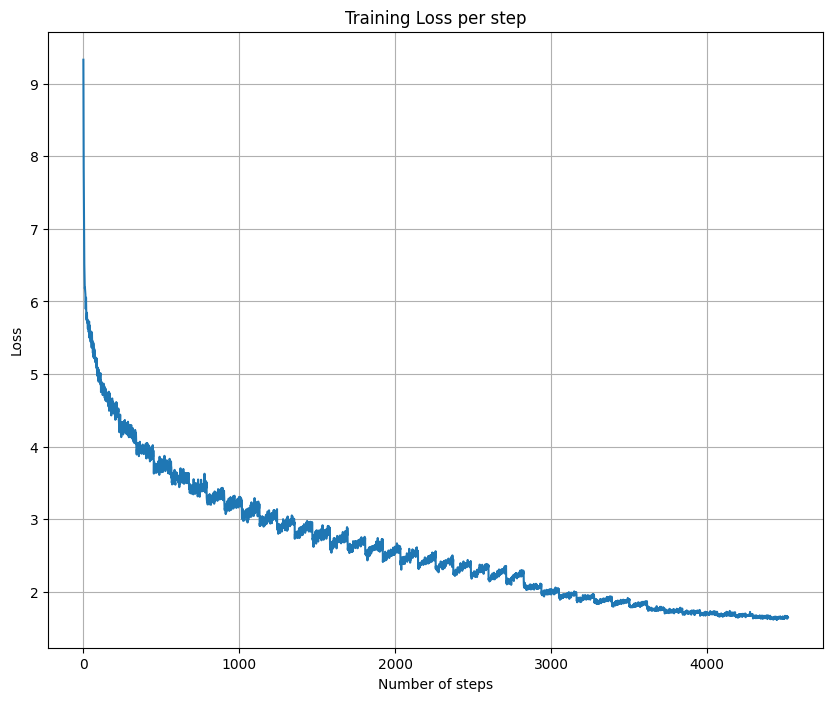

In [68]:
loss_steps = [item for sublist in loss_list for item in sublist]

plt.figure(figsize=(10,8))
plt.plot(loss_steps)
plt.xlabel("Number of steps")
plt.ylabel("Loss")
plt.title("Training Loss per step")
plt.grid(True)
plt.show()

### Loss per Epoch

In [66]:
len(loss_list)

40

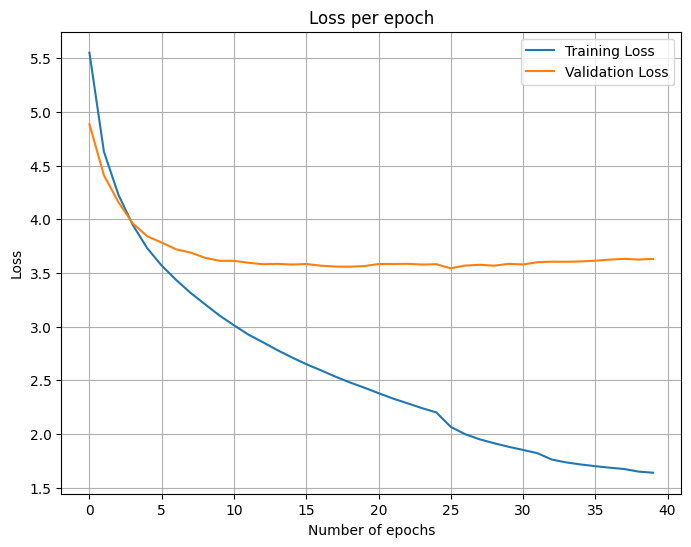

In [77]:
loss_epochs = [sum(sublist)/len(sublist) for sublist in loss_list]

plt.figure(figsize=(8,6))
plt.plot(loss_epochs, label="Training Loss")
plt.plot(val_list, label= "Validation Loss")
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.grid(True)
plt.show()

### Translation with the transformer

In [36]:
test_german_sentences = ["Ich liebe es, neue Sprachen zu lernen",
                         "Das Wetter ist heute wirklich schön",
                        "Könnten Sie mir bitte den Weg zum Bahnhof erklären?",
                        "Der große, alte Baum mit seinen weit verzweigten Ästen spendet an einem heißen Sommertag angenehmen Schatten"]

In [40]:


for i in range(len(test_german_sentences)):
    tokenized_test = de_byte_tokenizer(test_german_sentences[i], return_tensors='pt', return_token_type_ids=False, padding=True)
    print(tokenized_test.tokens())


['[BOS]', 'Ich', 'Ġliebe', 'Ġes', ',', 'Ġneue', 'ĠSpr', 'achen', 'Ġzu', 'Ġlernen', '[EOS]']
['[BOS]', 'Das', 'ĠWetter', 'Ġist', 'Ġheute', 'Ġwirk', 'lich', 'ĠschÃ¶n', '[EOS]']
['[BOS]', 'K', 'Ã¶n', 'n', 'ten', 'ĠSie', 'Ġm', 'ir', 'Ġb', 'itte', 'Ġden', 'ĠWeg', 'Ġzum', 'ĠBahnhof', 'ĠerklÃ¤ren', '?', '[EOS]']
['[BOS]', 'Der', 'ĠgroÃŁe', ',', 'Ġalte', 'ĠBaum', 'Ġmit', 'Ġseinen', 'Ġweit', 'Ġverz', 'wei', 'g', 'ten', 'ĠÃĦsten', 'Ġspendet', 'Ġan', 'Ġeinem', 'ĠheiÃŁen', 'ĠSommertag', 'Ġangene', 'hmen', 'ĠSchatten', '[EOS]']


In [59]:
model.to(device)
model.eval()

for i in range(len(test_german_sentences)):
    tokenized_test = de_byte_tokenizer(test_german_sentences[i], return_tensors='pt', return_token_type_ids=False, padding=True)
    input_tensor = tokenized_test["input_ids"]
    tgt_tensor = torch.tensor([BOS_IDX]).unsqueeze(0) 
    with torch.no_grad():

        for _ in range(100):

            input_tensor = input_tensor.to(device)
            tgt_tensor = tgt_tensor.to(device)

            output = model(input_tensor, tgt_tensor)

            next_token = output.argmax(dim=-1)[:,-1]

            tgt_tensor = torch.cat((tgt_tensor, next_token.unsqueeze(-1)), dim =-1)        

            if (next_token == EOS_IDX).any():
                break
        print(en_byte_tokenizer.batch_decode(input_tensor, skip_special_tokens=True, clean_up_tokenization_spaces=False))

[' sciss wind, furry all skateideosed']
[' river squad little crag fo']
['K prinnon bicyclistndard ofasiumowiving gettingsleeve?']
[' playerght, hikcks d whoeter narrowesgonoun c exercise interactpher themselves']


### BLEU Score Performance Metric

In [42]:
stoi = en_byte_tokenizer.get_vocab()

In [43]:
itos = {i : s for s, i in stoi.items()}

In [44]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

smoothing_function = SmoothingFunction().method1

In [126]:
# Ensure that your model is on the correct device and in eval mode
model.to(device)
model.eval()

# Define smoothing function for BLEU score calculation
smoothing_function = SmoothingFunction().method1

all_bleu_scores = []

start_time = time.time()
with torch.no_grad():
    for src_batch, tgt_batch in test_loader:
        # Move batch to the device
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)

        batch_bleu_scores = []

        # Initialize target tensor with BOS token
        tgt_input = torch.full((src_batch.size(0), 1), BOS_IDX, dtype=torch.long).to(device)  # Shape: [batch_size, 1]

        # Track which sequences have generated an EOS token
        eos_mask = torch.zeros(src_batch.size(0), dtype=torch.bool).to(device)

        # Autoregressive decoding loop
        for _ in range(50):  # Define max_length as per your needs
            output = model(src=src_batch, tgt=tgt_input)  # Predict next tokens for the whole batch
            next_token = output.argmax(dim=-1)[:, -1]  # Get next token predictions for all sentences in the batch

            # Append predicted token to tgt_input only for sequences that haven't generated EOS yet
            next_token[eos_mask] = BOS_IDX  # Use BOS_IDX as a placeholder for already completed sequences
            tgt_input = torch.cat((tgt_input, next_token.unsqueeze(-1)), dim=1)

            # Update eos_mask
            eos_mask = eos_mask | (next_token == EOS_IDX)

            # Stop if all sequences have generated an EOS token
            if eos_mask.all():
                break

        # Convert generated tokens to sentences
        predicted_sentences = []
        for i in range(tgt_input.size(0)):
            # Find the position of the first EOS token
            eos_pos = (tgt_input[i] == EOS_IDX).nonzero(as_tuple=True)[0]
            if eos_pos.numel() > 0:
                eos_pos = eos_pos[0].item()
            else:
                eos_pos = tgt_input.size(1)
            predicted_sentence = [itos[token.item()] for token in tgt_input[i][:eos_pos] if token != BOS_IDX]
            predicted_sentences.append(predicted_sentence)

        target_sentences = []
        for i in range(tgt_batch.size(0)):
            # Find the position of the first EOS token
            eos_pos = (tgt_batch[i] == EOS_IDX).nonzero(as_tuple=True)[0]
            if eos_pos.numel() > 0:
                eos_pos = eos_pos[0].item()
            else:
                eos_pos = tgt_batch.size(1)
            target_sentence = [itos[token.item()] for token in tgt_batch[i][:eos_pos] if token != BOS_IDX and token != PAD_IDX]
            target_sentences.append(target_sentence)

        # Calculate BLEU scores for the entire batch
        for pred, target in zip(predicted_sentences, target_sentences):
            bleu_score = sentence_bleu([target], pred, weights=(1, 0, 0, 0), smoothing_function=smoothing_function)
            batch_bleu_scores.append(bleu_score)

        # Add batch BLEU scores to all_bleu_scores
        all_bleu_scores.extend(batch_bleu_scores)

# Calculate the average BLEU score across all batches and sentences
average_bleu = sum(all_bleu_scores) / len(all_bleu_scores) if all_bleu_scores else 0.0
print(f"Average BLEU score on test set: {average_bleu:.4f}")
print(time.time() - start_time)

Average BLEU score on test set: 0.5518
19.78962779045105


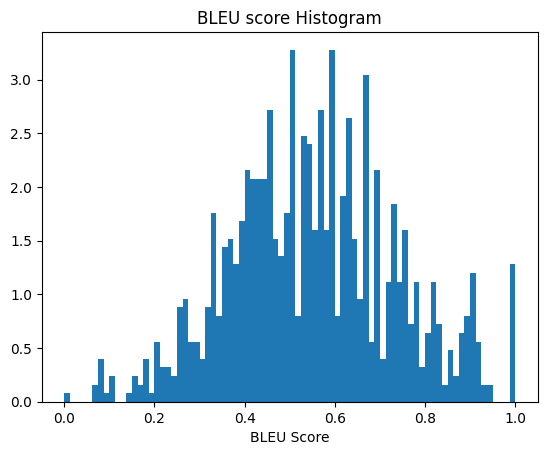

In [130]:
plt.hist(all_bleu_scores, bins=80, density=True)
plt.xlabel("BLEU Score")
plt.title("BLEU score Histogram")
plt.show()

### Translation On Test Set

In [56]:
model.to(device)
model.eval()

all_bleu_scores = []
best_sentences = []
worst_sentences = []

start_time = time.time()
with torch.no_grad():
    for src_batch, tgt_batch in test_loader:
        # Move batch to the device
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)

        batch_bleu_scores = []

        # Loop through each sentence in the batch
        for i in range(src_batch.size(0)):
            src = src_batch[i].unsqueeze(0)  # Take a single source sentence
            tgt = tgt_batch[i].unsqueeze(0)  # Take corresponding target sentence

            # Initialize target with BOS_IDX token for generation
            tgt_input = torch.tensor([[BOS_IDX]]).to(device)  # Shape: [1, 1]

            # Autoregressive decoding loop
            for _ in range(50):  # Define max_length as per your needs
                output = model(src=src, tgt=tgt_input)  # Predict next token
                next_token = output.argmax(dim=-1)[:, -1]  # Get next token prediction

                # Append predicted token to tgt_input
                tgt_input = torch.cat((tgt_input, next_token.unsqueeze(-1)), dim=1)

                # Stop if EOS_IDX token is generated
                if next_token.item() == EOS_IDX:
                    break

            # Convert tokens to words (predicted and target sentences)
            predicted_sentence = [itos[token.item()] for token in tgt_input.squeeze(0) if token != EOS_IDX and token != BOS_IDX]
            target_sentence = [itos[token.item()] for token in tgt.squeeze(0) if token != EOS_IDX and token != BOS_IDX and token != PAD_IDX]
            
            #predicted_sentence = en_byte_tokenizer.batch_decode(tgt_input, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            #target_sentence = en_byte_tokenizer.batch_decode(tgt, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            

            # Calculate BLEU score for the individual sentence
            bleu_score = sentence_bleu([target_sentence], predicted_sentence, weights=(1, 0, 0, 0), smoothing_function=smoothing_function)
            predicted_sentence = en_byte_tokenizer.batch_decode(tgt_input, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            target_sentence = en_byte_tokenizer.batch_decode(tgt, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            print("Predicted: ", "".join(predicted_sentence))
            print("Actual: ", "".join(target_sentence))
            print(f"BLEU Score = {bleu_score:.3f}\n")
            
            if bleu_score == 1:
                best_sentences.append([predicted_sentence, target_sentence])
            if bleu_score < 0.2:
                worst_sentences.append([predicted_sentence, target_sentence])
                    
            batch_bleu_scores.append(bleu_score)
                 

        # Add batch BLEU scores to all_bleu_scores
        all_bleu_scores.extend(batch_bleu_scores)
        

# Calculate the average BLEU score across all batches and sentences
average_bleu = sum(all_bleu_scores) / len(all_bleu_scores)
print(f"Average BLEU score on test set: {average_bleu:.4f}")
print(time.time() - start_time)

Predicted:  A man in a orange hat inspects something with an iron machine.
Actual:  A man in an orange hat starring at something.
BLEU Score = 0.615

Predicted:  A mostly white dog is walking across a grassy field with a green fence.
Actual:  A Boston Terrier is running on lush green grass in front of a white fence.
BLEU Score = 0.437

Predicted:  A girl in a karate uniform is using a microscope.
Actual:  A girl in karate uniform breaking a stick with a front kick.
BLEU Score = 0.606

Predicted:  Five people in skiing, and with trees in the background.
Actual:  Five people wearing winter jackets and helmets stand in the snow, with snowmobiles in the background.
BLEU Score = 0.465

Predicted:  People are looking at the top of a building.
Actual:  People are fixing the roof of a house.
BLEU Score = 0.600

Predicted:  A man dressed as a woman in a dark dress makes a pink balloon around a woman in a dark suit.
Actual:  A man in light colored clothing photographs a group of men wearing dark

In [46]:
len(best_sentences)

16

In [47]:
len(worst_sentences)

1

In [54]:
for i in best_sentences:
    print("Predicted: ", "".join(i[0]))
    print(f'Actual: {"".join(i[1])}\n')

Predicted:  Two brown dogs are running through the snow.
Actual: Two brown dogs are running through the snow.

Predicted:  A man wearing an orange shirt and helmet.
Actual: A man wearing an orange shirt and helmet.

Predicted:  A dog runs with a yellow toy outside.
Actual: A dog runs outside with a yellow toy.

Predicted:  Many people are sitting around a tent outside.
Actual: Many people are sitting around a tent outside.

Predicted:  A black boy is sitting in the sand.
Actual: A black boy is sitting in the sand.

Predicted:  Two soccer teams are on the field.
Actual: Two soccer teams are on the field.

Predicted:  A girl dressed in black is posing for the camera.
Actual: A girl dressed in black is posing for the camera.

Predicted:  A man stands on a rocky cliff overlooking a body of water.
Actual: A man stands on a rocky cliff overlooking a body of water.

Predicted:  Two men sitting in a restaurant.
Actual: Two men sitting in a restaurant.

Predicted:  A man in a suit is sitting at

In [57]:
for i in worst_sentences:
    print("Predicted: ", "".join(i[0]))
    print(f'Actual: {"".join(i[1])}\n')

Predicted:  Women dressed as a Santa clause playing a game.
Actual: Women, wearing traditional clothing, are reenacting native life.

Predicted:  Two hipplw are being transp by two horses, one of the top of the top of the top of the top of the top of the top of the top of the top of the top of the top of the top of the top of
Actual: Two female members of team USA performing a jump high-five surrounded by two other female members.

Predicted:  This woman is just got done her form with the friend.
Actual: This lady has heard a funny joke and laughing.

Predicted:  Orends to reach the ball when they are out.
Actual: Basketball players shoot for a goal during a game.

Predicted:  The economy is shacking and affecting China.
Actual: The Dali Lama during a reception where participants have brought carnations, parasols and prayer flags.

Predicted:  A chipping away from an iron bar.
Actual: An army officer is inspecting something.

Predicted:  A child with a number 41 equipment going.
Actual